# Programming assignment 1
Following the first problem in the written assignment, set $ρ_{22}$ = 1 and zeros in else- where, solve the system u.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dia_array  # if dia_array is not able, use dia_matrix
from scipy.sparse import dia_matrix
from numba import jit, njit, prange
from numba import set_num_threads

# Set the number of threads to use for numba
nthreads = 8
set_num_threads(nthreads)

In [2]:
def generate_the_laplace_matrix_with_size(N=4):
    """
    assume sqrt(N) is an integer.

    N is the number of grid points in one direction.

    """
    nsq = N*N
    A   = np.zeros((nsq,nsq))

    def init_1_4_1_matrix(N=4):
        ex = np.ones(nsq)
        data = np.array([-ex, 4 * ex, -ex])
        offset = np.array([-1, 0, 1])
        u = dia_matrix((data, offset), shape=(N, N)).toarray()
        return u

    def init_one_matrix(N):
        return -np.identity(N)

    def init_zero_matrix(N):
        return np.zeros((N,N))
    
    d_matrix = init_1_4_1_matrix(N)
    o_matrix = init_one_matrix(N)
    z_matrix = init_zero_matrix(N)
    
    '''
    for i in range(N):
        for j in range(N):
            if i == j:
                submartix = init_1_4_1_matrix(N)
            elif abs(i-j) == 1:
                submartix = init_one_matrix(N)
            else:
                submartix = init_zero_matrix(N)
            
            for ii in range(N):
                for jj in range(N):
                    A[i*N+ii][j*N+jj] = submartix[ii][jj]
    '''
    A = init_matrix_kernel(N, A, d_matrix, o_matrix, z_matrix)
    return A

# use numba to speed up the matrix generation
@njit(parallel=True)
def init_matrix_kernel(N,A,d_matrix,o_matrix, z_matrix):
    for i in prange(N):
        for j in prange(N):
            if (i==j):
                submatrix = d_matrix
            elif (abs(i-j)==1):
                submatrix = o_matrix
            else:
                submatrix = z_matrix
            
            for i2 in range(N):
                for j2 in range(N):
                    ii = i2 + i*N
                    jj = j2 + j*N
                    A[ii,jj] = submatrix[i2,j2]   
    return A

# include boundary conditions
def generate_the_rhs_vector_with_size(N=3):
    b = np.zeros(N*N)
    b[4] = 1
    return b

# convert the solution vector to the finite difference grids u[i,j]
def convert_solution(x):
    usize = np.sqrt(len(x))
    u = x.reshape(int(usize),int(usize)).transpose()
    return u

In [3]:
# check the format of A & b
N = 3
A = generate_the_laplace_matrix_with_size(N)
print(A)
b = generate_the_rhs_vector_with_size(N)
print(b)

[[ 4. -1.  0. -1. -0. -0.  0.  0.  0.]
 [-1.  4. -1. -0. -1. -0.  0.  0.  0.]
 [ 0. -1.  4. -0. -0. -1.  0.  0.  0.]
 [-1. -0. -0.  4. -1.  0. -1. -0. -0.]
 [-0. -1. -0. -1.  4. -1. -0. -1. -0.]
 [-0. -0. -1.  0. -1.  4. -0. -0. -1.]
 [ 0.  0.  0. -1. -0. -0.  4. -1.  0.]
 [ 0.  0.  0. -0. -1. -0. -1.  4. -1.]
 [ 0.  0.  0. -0. -0. -1.  0. -1.  4.]]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]


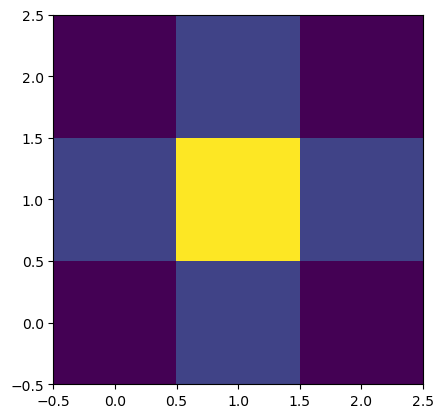

In [4]:
from scipy import linalg
x = linalg.solve(A, b)
u = convert_solution(x)
plt.imshow(u.T,origin="lower")

# Programming assignment 2
* Consider a 128 x 128 grids in a domain ($-5<x<5$ and $-5<y<5$)
* Assume $\rho(r)= \exp(-\frac{5}{4}r_{1}^2)+\frac{3}{2}\exp(-r_2^2)$
* where $r_1=(x+1.5)^2+y^2$ and $r_2=(x-1.5)^2+Y^2$
* Assume periodic boundary condition.
* solve the corresponding potential of this source function. 
* Draw color and contour plots of the source function and the solution potential.

In [17]:
import numpy as np
from scipy.sparse import dia_array  # if dia_array is not able, use dia_matrix
from scipy.sparse import dia_matrix
from scipy.sparse import csc_matrix
import scipy.sparse.linalg as splinalg
from numba import jit, njit, prange
import matplotlib.pyplot as plt
from numba import set_num_threads

# Set the number of threads to use for numba
nthreads = 8
set_num_threads(nthreads)

In [18]:
# generate the N*N rho matrix with denisty filed
def generate_rho(N, xmin=-5, xmax=5, ymin=-5,ymax=5):
    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    r1     = (xx+1.5)**2 + yy**2
    r2     = (xx-1.5)**2 + yy**2
    rho    = np.exp(-5/4*(r1**2))+3/2*np.exp(-r2**2)
    return rho

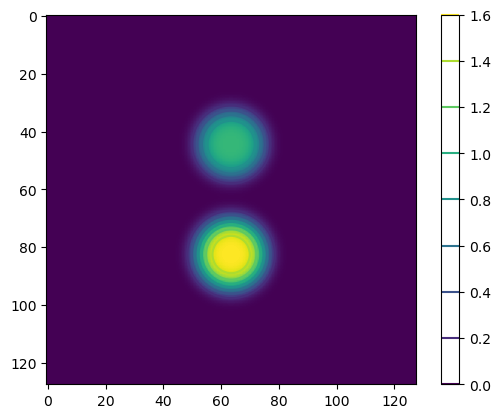

In [21]:
# visualize the density field
rho = generate_rho(128)
plt.imshow(rho)
plt.contour(rho)
plt.colorbar()


In [8]:
def generate_mesh(nx, ny, buff=1, 
                  xmin=0.0, xmax=1.0, ymin=0.0, ymax=1.0):
    """
    Generate 2D mesh grids for solving Laplace equation.

    Parameters
    ----------
    nx : int
        Number of grid points in x direction.
    ny : int
        Number of grid points in y direction.
    buff : int
        Number of ghost cells around the domain.
    xmin : float
        Minimum value of x.
    xmax : float
        Maximum value of x.
    ymin : float
        Minimum value of y.
    ymax : float
        Maximum value of y.

    Returns
    -------
    u : 2D numpy array
        Initial guess
    x : 2D numpy array
        Mesh grid for x.
    y : 2D numpy array
        Mesh grid for y.

    dx : float
        Grid spacing in x.
    dy : float
        Grid spacing in y.
        
    """
    #TODO:
    # 1. Generate mesh grid for x and y
    # 2. Calculate grid spacing dx and dy
    # 3. Return x, y, dx, dy

    u = np.zeros((nx+2*buff, ny+2*buff))
    x = np.linspace(xmin, xmax, nx+2*buff)
    y = np.linspace(ymin, ymax, ny+2*buff)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    return u, x, y, dx, dy

# Combiation of three methods
@njit(parallel=True)
def jocobi(u, uold, rho, omega, nx, ny, dx, dy):
    # u[ny+2*buff, nx+2*buff], from 1 to ny+1 is the real domain without ghost cells
    for j in prange(1, ny-1):
        for i in prange(1, nx-1):
            u[i, j] = 0.25*(uold[i-1, j] + uold[i+1, j] + uold[i, j-1] + uold[i, j+1] - dx**2*rho[i,j])
    return u

@njit(parallel=True)
def gauss_seidel(u, uold, rho, omega, nx, ny, dx, dy):
    for j in prange(1, ny-1):
        for i in prange(1, nx-1):
            u[i, j] = 0.25*(u[i-1, j] + uold[i+1, j] + u[i, j-1] + uold[i, j+1] - dx**2*rho[i,j])
    return u

@njit(parallel=True)
def successive_over_relaxation(u, uold, rho, omega, nx, ny, dx, dy):
    u = gauss_seidel(u, uold, rho, omega, nx, ny, dx, dy)
    u = (1.0 - omega)*uold + omega*u
    return u

def update_bc(u):
    u[0,:] = 0.0    # left boundary
    u[-1,:] = 0.0   # right boundary
    u[:,0] = 0.0    # bottom boundary
    u[:,-1] = 0.0   # top boundary
    return u

def relax(u, tolerence, rho, maxiter=10, method = 'jocobi', omega=1.0):
    
    if method == 'jocobi':
        iter_func = jocobi
    elif method == 'gauss_seidel':
        iter_func = gauss_seidel
    elif method == 'sor':
        iter_func = successive_over_relaxation
    else:
        raise ValueError('Invalid method, choose from jocobi, gauss_seidel, sor')

    nx, ny = u.shape # including ghost cells
    u = update_bc(u)
    err_list = []
    iter = []
    for n in range(maxiter):
        uold = u.copy()
        u = iter_func(u, uold, rho, omega, nx, ny, dx, dy)
        err = np.linalg.norm(u - uold)
        iter.append(n)
        err_list.append(err)
        if err < tolerence:
            break

    return u, err_list, iter


Text(0.5, 1.0, '128x128 Gauss-Seidel')

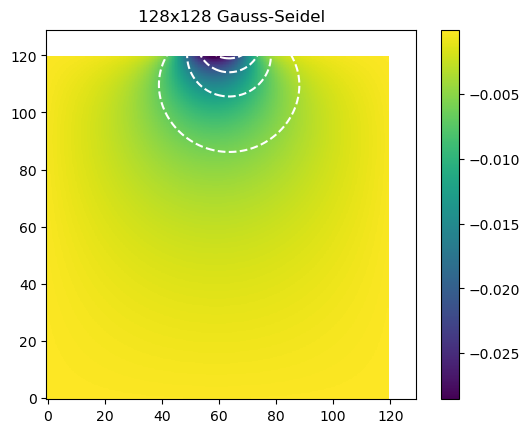

In [12]:
# 128 gauss_seidel
u, x, y, dx, dy = generate_mesh(128,128, 1, xmin=-5, xmax=5, ymin=-5, ymax=5)
rho = generate_rho(128, 128, 1)
u128_g, err128_g, iter128_g = relax(u, tolerence=1e-6, rho=rho, maxiter=1000000, method='gauss_seidel', omega=1.0)

# Visualize the solution
plt.imshow(u128_g[5:-5, 5:-5], origin='lower')
plt.colorbar()
plt.contour(u128_g, colors='w')
plt.title('128x128 Gauss-Seidel')